In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding = 'ISO-8859-1')
df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054,128900.0,81
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523,340.0,331
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568,107160.0,167


In [6]:
# Preprocessing. 

# Will only keep positive and neutral sentiments, and only use text and sentiment columns

df = df[['text', 'sentiment']]
df = df = df[df['sentiment']!='neutral']

In [7]:
print(len(df))
print(df.isna().sum())
counts = df['sentiment'].value_counts()
n = len(df)
print("Positive Tweets:", counts['positive']/n*100, '%')
print("Negative Tweets:", counts['negative']/n*100, '%')

#no null values, data is not very skewed, we're good to go

16363
text         0
sentiment    0
dtype: int64
Positive Tweets: 52.44759518425717 %
Negative Tweets: 47.55240481574283 %


In [8]:
# making a word dictionary which holds positiove count in 0 position and negative in position 1, including removing stopwords and stemming
def has_digits(input_string):
    return any(char.isdigit() for char in input_string)

stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()
punct = string.punctuation


word_dict = dict()

df['text'] = df['text'].apply(lambda x: x.lower())

for index, row in df.iterrows():
    text=row['text']
    senti = row['sentiment']
    tokens = word_tokenize(text)
    for word in tokens:
        if word not in stopwords and word not in punct and has_digits(word)==False:
            word = stemmer.stem(word)
            if word not in word_dict.keys():
                if senti == 'positive':
                    word_dict[word] = [1,1,0]
                else:
                    word_dict[word]=[1,1,0]
            else:
                if senti == 'positive':
                    word_dict[word][1]+=1
                else:
                    word_dict[word][0]+=1 

def process_text(text):
    feature_vector=[1,0,0]
    tokens = word_tokenize(text)
    for word in tokens:
        word = stemmer.stem(word)
        if word not in stopwords and word not in punct and has_digits(word)==False:
            try:
                feature_vector[1]+=word_dict[word][1]
                feature_vector[2]+=word_dict[word][2]
            except:
                continue
    return feature_vector


In [9]:
feature = []

for text in df['text']:
    feature.append(process_text(text))


Accuracy:  0.6120952962736713


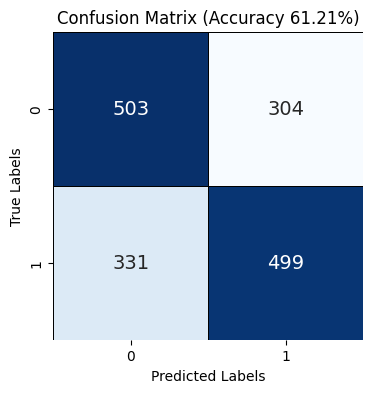

In [10]:
#logistic regression

X = np.array(feature)
Y = np.array(df['sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

model1 = LogisticRegression()

model1.fit(X_train,Y_train)

predictions = model1.predict(X_test)

accuracy = accuracy_score(Y_test,predictions)
print('Accuracy: ', accuracy)

cm = confusion_matrix(Y_test,predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            annot_kws={"size": 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Accuracy {:.2f}%)'.format(accuracy * 100))
plt.show()

In [11]:
# let's see if we can increase the accuracy

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [50, 100, 200]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 0.001, 'max_iter': 50, 'solver': 'liblinear'}


In [12]:
model2 = LogisticRegression(C=0.001,max_iter=50,solver='liblinear')

model2.fit(X_train,Y_train)

predictions = model1.predict(X_test)

accuracy = accuracy_score(Y_test,predictions)
print('Accuracy: ', accuracy)

#accuracy didn't significantly increase


Accuracy:  0.6120952962736713
